## Modules à importer

In [26]:
import math
import scipy
import pickle
import astropy
import ztfquery
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from variaIa import tools_ar
from variaIa import baserate
from variaIa import stretchevol
from scipy.stats import poisson
from matplotlib.lines import Line2D
from astropy.cosmology import Planck15
from IPython.display import display, Latex
from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full, z_max
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "EB Garamond",
    "axes.labelsize": 'x-large',
    "xtick.labelsize": 'x-large',
    "ytick.labelsize": 'x-large'})
plt.rcParams['figure.facecolor'] = 'w'
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [9]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools_ar.cons, su=tools_ar.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
surveysnl = surveys[0:1]+surveys[2:]

## Minimisation des modèles à mettre dans le _pandas_

In [10]:
gen = stretchevol.generic()
gen.set_model('Evol1G1M2S')

assymPS1 = gen.fit(df[df['survey'] == 'PS1'])

assymSDSS = gen.fit(df[df['survey'] == 'SDSS'])

assymSNLS = gen.fit(df[df['survey'] == 'SNLS'])

assym = {'SDSS': assymSDSS,
         'PS1': assymPS1,
         'SNLS': assymSNLS}

## Modèle _base_ pour comparaison

In [13]:
gen.set_model('Evol3G2M2S')
baseSNF = gen.fit(df[df['survey'] == 'SNF'])

baseTOT = gen.fit(df)

### Définition likelihood generic

In [14]:
def assym_law_gen(x, param):
    return(assymPS1.likelihood_tot(x, np.zeros(len(x)), param[0], param[1], param[2]))

def model_law_gen(deltaz, xx, param_hesse):
    """Function to get laws with parameters taken wrt there hesse error"""
    return np.sum(baseTOT.likelihood_tot(deltaz, xx, 0,
                                         param_hesse[0],
                                         param_hesse[1], param_hesse[2],
                                         param_hesse[3], param_hesse[4]), axis=1)/len(deltaz)

# Pantheon dictionnaries

## Définition de _cov_ ASYM pour sélection aléatoire des paramètres

In [21]:
cov = dict()
mean = dict()
param_hesse_mat = dict()
models_hesse = dict()
models_std = dict()

p_sco = {'SDSS': [1.141, 1.653, 0.100],
         'PS1': [0.365, 0.963, 0.514],
         'SNLS': [0.964, 1.232, 0.282]}

xlin = np.linspace(-5, 5, 3000)

for survey in surveys[1:-1]:
    # cov[survey] = im.Minuit.matrix(assym[survey].m_tot)
    cov[survey] = assym[survey].m_tot.covariance
    mean[survey] = [assym[survey].m_tot.values[i] for i in range(3)]
    param_hesse_mat[survey] = scipy.stats.multivariate_normal.rvs(mean=mean[survey], cov=cov[survey], size=500)
    models_hesse[survey] = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat[survey]]
    models_hesse[survey] = np.asarray(models_hesse[survey])
    models_std[survey] = np.std(models_hesse[survey], axis=0)

## Définition de _cov_ BASE pour sélection aléatoire des paramètres

In [22]:
cov_base = dict()
mean_base = dict()
param_hesse_mat_base = dict()
models_hesse_base = dict()
models_std_base = dict()

xx1 = np.linspace(-5, 5, 3000)

deltaz = {'SNF': stretchevol.MockEvol().delta(df[df['survey'] == 'SNF'].redshifts.values),
          'SDSS': stretchevol.MockEvol().delta(df[df['survey'] == 'SDSS'].redshifts.values),
          'PS1': stretchevol.MockEvol().delta(df[df['survey'] == 'PS1'].redshifts.values),
          'SNLS': stretchevol.MockEvol().delta(df[df['survey'] == 'SNLS'].redshifts.values)}

for survey in surveys[0:-1]:
    cov_base[survey] = baseTOT.m_tot.covariance
    mean_base[survey] = [baseTOT.m_tot.values[i] for i in range(5)]
    param_hesse_mat_base[survey] = scipy.stats.multivariate_normal.rvs(mean=mean_base[survey], cov=cov_base[survey], size=500)
    
    models_hesse_base[survey] = [model_law_gen(deltaz[survey], xx1[:,None], param_hesse)
                                 for param_hesse in param_hesse_mat_base[survey]]
    models_hesse_base[survey] = np.asarray(models_hesse_base[survey])
    models_std_base[survey] = np.std(models_hesse_base[survey], axis=0)

## PDF dict

In [23]:
def pdfS(x):
    return assymSDSS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymSDSS.param['mu'],
                                    assymSDSS.param['sigma_m'],
                                    assymSDSS.param['sigma_p'])

def pdfP(x):
    return assymPS1.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymPS1.param['mu'],
                                    assymPS1.param['sigma_m'],
                                    assymPS1.param['sigma_p'])

def pdfN(x):
    return assymSNLS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymSNLS.param['mu'],
                                    assymSNLS.param['sigma_m'],
                                    assymSNLS.param['sigma_p'])

def pdfS_sco(x):
    return assymSDSS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['SDSS'][0],
                                    p_sco['SDSS'][1],
                                    p_sco['SDSS'][2])

def pdfP_sco(x):
    return assymPS1.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['PS1'][0],
                                    p_sco['PS1'][1],
                                    p_sco['PS1'][2])

def pdfN_sco(x):
    return assymSNLS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['SNLS'][0],
                                    p_sco['SNLS'][1],
                                    p_sco['SNLS'][2])

pdfA = {'SDSS': pdfS,
        'PS1': pdfP,
        'SNLS': pdfN}

pdfA_sco = {'SDSS': pdfS_sco,
            'PS1': pdfP_sco,
            'SNLS': pdfN_sco}

## Tracé

In [42]:
def plot_pdfs(surveyname,
              color_p="C2", color_s="0.2", color_mb='k',
              show_legend=False, ticks_size=12,
              zo_base=2, zo_asym=4, zo_sco=3, zo_mb=10,
              lw_col=2, lw_mod=2, lw_sco=1, lw_vline=1,
              ls_col='-', ls_mod='-', ls_sco='--',
              show_asym=True, show_sco=True,
              show_base=True, norm_max=True, alpha_base=.1,
              show_mean_base=True, show_mean_base_std=False, alpha_mb_std=.3,
              show_hist=True, ecolor_h=plt.cm.cividis(0.5, 0.5), fcolor_h=plt.cm.cividis(0.5, 0.1),
              use_continuous_redshift=False, n_continuous=50,
              perc_zmin=5, perc_zmax=95):
    
    fig = plt.figure(figsize=[6, 4])
    ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
    
    x_linspace = np.linspace(-5, 5, 3000)
    
    if show_asym:
        ax.plot(x_linspace,
                pdfA[surveyname](x_linspace),
                color=color_p,
                lw=lw_mod, ls=ls_mod,
                label=surveyname,
                zorder=zo_asym)

        ax.fill_between(x_linspace,
                        pdfA[surveyname](x_linspace) + models_std[surveyname],
                        pdfA[surveyname](x_linspace) - models_std[surveyname],
                        color=color_p,
                        lw=0, alpha=.2,
                        zorder=zo_asym)

        #ax.vline(assym[surveyname].param['mu'], ymin=0, ymax=np.max(pdfA[surveyname](x_linspace)),
        #         color=color_p, alpha=.5, linewidth=lw_vline)
    
    if show_sco:
        mu_s = p_sco[surveyname][0]
        sigma_m_s = p_sco[surveyname][1]
        sigma_p_s = p_sco[surveyname][2]

        pdf_SCO = assym[surveyname].likelihood_tot(x_linspace,
                                                   np.zeros(len(x_linspace)),
                                                   mu_s,
                                                   sigma_m_s,
                                                   sigma_p_s)

        ax.plot(x_linspace,
                pdf_SCO,
                color=color_s, label='Scolnic',
                lw=lw_sco, ls=ls_sco,
                zorder=zo_sco)

        #ax.vline(mu_s, 0, np.max(pdf_SCO),
        #         color=color_s, alpha=.5,
        #         ls=ls_sco, linewidth=lw_vline)
    
    dgmap = plt.cm.get_cmap('coolwarm')
    df_full_used = df_full[df_full['survey'] == surveyname]
    nb_base = len(df_full_used.redshifts)
    i = 0
    
    z_m, z_p = np.percentile(df_full_used.redshifts, [perc_zmin, perc_zmax])
    
    used_redshift = df_full_used.redshifts if not use_continuous_redshift else \
    np.linspace(*np.percentile(df_full_used.redshifts, [0, 100]), n_continuous)
    mult = 1

    if show_base:
        for z in used_redshift: #np.linspace(0.05, 1, nb_base)[:-1]:
            pdf = baseTOT.likelihood_tot(baseTOT.delta(z),
                                         x_linspace, np.zeros(len(x_linspace)),
                                         baseTOT.param['aa'],
                                         baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                         baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
            norm_ = 1 if not norm_max else np.max(pdfA[surveyname](x_linspace))/np.max(pdf)
            ax.plot(x_linspace,
                    mult*norm_*pdf,
                    color=dgmap((z-z_m)/(z_p-z_m)), alpha=alpha_base,
                    lw=lw_col, ls=ls_col, zorder=zo_base)
            i += 1
    
    df_used = df[df['survey'] == surveyname]
    pdfmodel = baseTOT.likelihood_tot(deltaz[surveyname], x_linspace[:,None], 0, #np.mean(dx1),
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
    
    if show_mean_base and not show_mean_base_std:
        ax.plot(x_linspace,
                np.sum(pdfmodel, axis=1)/len(deltaz[surveyname]),
                color=color_mb,
                label='Mean base model', zorder=zo_mb)
    
    if show_mean_base and show_mean_base_std:
        ax.plot(x_linspace,
                mult*np.sum(pdfmodel, axis=1)/len(deltaz[surveyname]),
                color=color_mb,
                label='Mean base model', zorder=zo_mb)
        ax.fill_between(x_linspace,
                mult*np.sum(pdfmodel, axis=1)/len(deltaz[surveyname])-models_std_base[surveyname],
                mult*np.sum(pdfmodel, axis=1)/len(deltaz[surveyname])+models_std_base[surveyname],
                color=color_mb, alpha=alpha_mb_std, lw=0,
                zorder=zo_mb)
        
    if show_hist:
        ax.hist(df_used.stretchs, bins='auto',
                density=True, histtype='step', fill=True, zorder=1,
                edgecolor=ecolor_h, facecolor=fcolor_h)# alpha=0.3)
    
    #ax.imshow(img, extent=[-3.9, 3.2, 0, 34], aspect='auto')
    
    ax.set_xlim([-3, 3])
    #ax.set_ylim([0, 0.65])
    ax.set_ylim(ymin=0)#[0, np.max(pdfA[surveyname](x_linspace)+models_std[surveyname])+0.01])
                                                                          
    ax.set_ylabel('Probabilité', fontsize='x-large')
    ax.set_xlabel('$x_1$', fontsize='x-large')
    
    ax.tick_params(labelsize=ticks_size)
    
    if show_legend:
        ax.legend(ncol=1, loc='upper left')
    
    return(fig, ax)

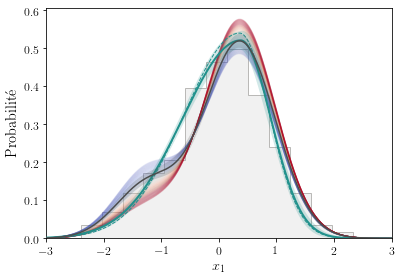

In [44]:
surveyname = 'PS1'
fig, ax = plot_pdfs(surveyname,
                    color_p=plt.cm.viridis(0.5), color_s=plt.cm.viridis(0.5), lw_sco=1,
                    #color_p=colors[surveyname], color_s=colors[surveyname],
                    show_legend=False, ticks_size=12,
                    show_base=True, norm_max=False, alpha_base=0.05, lw_col=1,
                    show_mean_base_std=True, alpha_mb_std=0.20, color_mb="0.3",
                    use_continuous_redshift=True, n_continuous=200)

path = '../../../Images/pdf/bbc_comp_' + surveyname + '_hist-nr.pdf'
fig.savefig(path, bbox_inches='tight')
path = '../../../Images/png/bbc_comp_' + surveyname + '_hist-nr.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

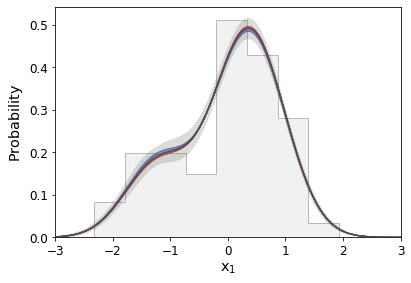

In [84]:
surveyname = 'SNF'
fig, ax = plot_pdfs(surveyname,
                    #color_p=plt.cm.viridis(0.5), color_s=plt.cm.viridis(0.5), lw_sco=1,
                    show_asym=False, show_sco=False,
                    color_p=colors[surveyname], color_s=colors[surveyname],
                    show_base=True, norm_max=False, alpha_base=0.05, lw_col=1,
                    show_mean_base_std=True, alpha_mb_std=0.20, color_mb="0.3",
                    use_continuous_redshift=True, n_continuous=200)


path = '../../Images/bbc_comp_' + surveyname + '_hist-nr.pdf'
fig.savefig(path, bbox_inches='tight')
path = '../../Images/png/bbc_comp_' + surveyname + '_hist-nr.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

# Associated graphs

## Functions definitions

In [11]:
with open('../../Data/ALL_results', 'rb') as f:
    res_ALL = pickle.load(f)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*res_ALL['mu_1']
      + (1-delta(z))*(baseTOT.get_a(res_ALL['aa'])*res_ALL['mu_1']
                      + (1 - baseTOT.get_a(res_ALL['aa']))*res_ALL['mu_2']))

with open('../../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] +
        (1-delta(z))*(baseTOT.get_a(res_SNF['aa'])*res_SNF['mu_1']
                      + (1-baseTOT.get_a(res_SNF['aa']))*res_SNF['mu_2']))

def delta(z):
    return stretchevol.MockEvol().delta(z)

## xmean definitions

In [12]:
z_linspace = np.linspace(0, 1.4, 3000)
x_linspace = np.linspace(-10, 10, 1e7)

xmean_asym = dict()
xmean_asym_sco = dict()

for survey in surveys[1:-1]:
    xmean_asym[survey] = np.sum(x_linspace*pdfA[survey](x_linspace))/np.sum(pdfA[survey](x_linspace)) 
    xmean_asym_sco[survey] = np.sum(x_linspace*pdfA_sco[survey](x_linspace))/np.sum(pdfA_sco[survey](x_linspace)) 

## Simple BBC-stretchevol

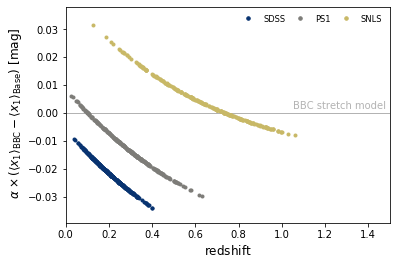

In [15]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])

alpha = 0.156

for survey in surveys[1:-1]:
    #ax.plot(df_full[df_full['survey'] == survey].redshifts,
    #        alpha*(xmean_asym_sco[survey] - age_law_snf(df_full[df_full['survey'] == survey].redshifts)),
    #        color=colors[survey], lw=2, ls='None', marker='.', alpha=.3, ms=3, zorder=6)
    
    ax.plot(df_full[df_full['survey'] == survey].redshifts,    
            alpha*(xmean_asym_sco[survey] - age_law_all(df_full[df_full['survey'] == survey].redshifts)),    
            color=colors[survey], lw=2, ls='None', marker='.',    
            zorder=6)
    
ax.hline(0, zorder=2, color="0.7", lw=1)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="large")
ax.set_ylabel(r" $\alpha\times\left(\langle x_1 \rangle_{\mathrm{BBC}} - \langle x_1 \rangle_{\mathrm{Base}}\right)$ [mag]", fontsize="large")

#ax.set_ylim(-0.52, 0.52)
ax.set_ylim((-0.03941893539802042, 0.03802656703727667))
#ax.set_xlim(0.01, 1.2)
ax.set_xlim(0, 1.5)
#ax.set_xscale('log')

ax.text(0.99, 0.52, 'BBC stretch model',
        va='bottom', ha='right', transform=ax.transAxes,
        color='0.7')

SDSSleg = Line2D([0], [0], color=colors['SDSS'],linewidth=0, marker='.', ms=7)
PS1leg = Line2D([0], [0], color=colors['PS1'],linewidth=0, marker='.', ms=7)
SNLSleg = Line2D([0], [0], color=colors['SNLS'],linewidth=0, marker='.', ms=7)
labels = ['SDSS', 'PS1', 'SNLS']

ax.legend([SDSSleg, PS1leg, SNLSleg], labels, columnspacing=0.8,
           ncol=3, loc='upper right', frameon=False, fontsize='small')

fig.savefig('../../Images/BBC_-stretchevol.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/BBC_-stretchevol.png', bbox_inches='tight', dpi=600)

## Combined bins definitions

In [42]:
df_bias = df_full[df_full['survey'].isin(['PS1','SDSS','SNLS'])]

def get_bias(df_line, alpha=0.156):
    meanBBC = xmean_asym_sco[df_line.survey]
    meanBASE = age_law_all(df_line.redshifts)
    return(alpha*(meanBBC - meanBASE))

df_bias['bias'] = np.asarray([get_bias(df_bias.iloc[l]) for l in range(len(df_bias))])

z_bin = np.linspace(0, 1.5, 30)
df_bias['zbin'] = np.digitize(df_bias.redshifts, z_bin)

df_bias_grouped = df_bias.groupby('zbin').mean()

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## Advanced BBC-stretchevol + cosmology

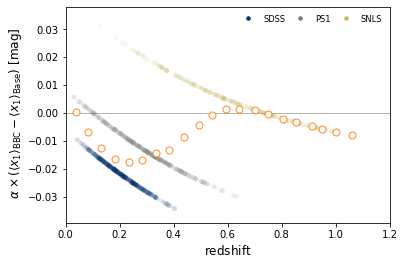

In [43]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])

prop=dict(lw=2, ls='None', marker='o', ms=5, alpha=.1, mew=0, zorder=5)

for survey in surveys[1:-1]:
    ax.plot(df_full[df_full['survey'] == survey].redshifts,    
            alpha*(xmean_asym_sco[survey] - age_law_all(df_full[df_full['survey'] == survey].redshifts)),    
            color=colors[survey], **prop)

ax.plot(df_bias_grouped.redshifts,
        df_bias_grouped.bias, ls='None',
        marker='o', mec="C1", mfc='w',
        color='C1', ms=7, alpha=.9, zorder=6)

ax.axhline(0, color="0.7", lw=1, zorder=1)
ax.set_xlim(0, 1.2)
ax.set_ylim((-0.03941893539802042, 0.03802656703727667))

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="large")
ax.set_ylabel(r" $\alpha\times\left(\langle x_1 \rangle_{\mathrm{BBC}} - \langle x_1 \rangle_{\mathrm{Base}}\right)$ [mag]", fontsize="large")

SDSSleg = Line2D([0], [0], color=colors['SDSS'],linewidth=0, marker='.', ms=7)
PS1leg = Line2D([0], [0], color=colors['PS1'],linewidth=0, marker='.', ms=7)
SNLSleg = Line2D([0], [0], color=colors['SNLS'],linewidth=0, marker='.', ms=7)
labels = ['SDSS', 'PS1', 'SNLS']

ax.legend([SDSSleg, PS1leg, SNLSleg], labels, columnspacing=0.8,
           ncol=3, loc='upper right', frameon=False, fontsize='small')

fig.savefig('../../Images/BBC_-stretchevol_grouped.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/BBC_-stretchevol_grouped.png', bbox_inches='tight', dpi=600)

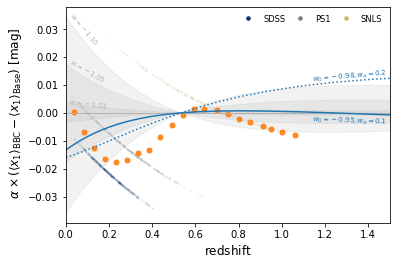

In [203]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])

prop=dict(lw=2, ls='None', marker='.', ms=4, alpha=.1, mew=0)

for survey in surveys[1:-1]:
    ax.plot(df_full[df_full['survey'] == survey].redshifts,    
            alpha*(xmean_asym_sco[survey] - age_law_all(df_full[df_full['survey'] == survey].redshifts)),    
            color=colors[survey], **prop)

ax.plot(df_bias_grouped.redshifts,
        df_bias_grouped.bias, ls='None', marker='o',
        color='C1', ms=5, alpha=.9)

zz = 10**np.linspace(-3, 3, 100)
wcdm = astropy.cosmology.FlatwCDM(70, 0.30, w0=-1)
REFZ = 0.5
for w in [[-0.90, -1.10], [-0.95, -1.05],[-0.99, -1.01]]:
    deltaup = wcdm.distmod(zz) -astropy.cosmology.FlatwCDM(70, 0.30, w0=w[0]).distmod(zz)
    deltalow = wcdm.distmod(zz)-astropy.cosmology.FlatwCDM(70, 0.30, w0=w[1]).distmod(zz)
    ax.fill_between(zz,
                    deltaup-deltaup[np.argmin(np.abs(zz-REFZ))],
                    deltalow-deltalow[np.argmin(np.abs(zz-REFZ))],
                    color="0.5", alpha=0.1)

ax.text(0.01, 0.03, r'$w = -1.10$', color="0.7", fontsize='x-small',
        rotation=-50, va='center', ha='left')
ax.text(0.01, 0.015, r'$w = -1.05$', color="0.7", fontsize='x-small',
        rotation=-30, va='center', ha='left')
ax.text(0.01, 0.0035, r'$w = -1.01$', color="0.7", fontsize='x-small',
        rotation=-7, va='center', ha='left')

ax.axhline(0, color="0.7", lw=1)
ax.set_xlim(0, 1.5)

delta_ = wcdm.distmod(zz) -astropy.cosmology.Flatw0waCDM(70, 0.30, w0=-0.95, wa=-0.1).distmod(zz)

ax.plot(zz,
       delta_-delta_[np.argmin(np.abs(zz-REFZ))],
       color='C0')

delta_ = wcdm.distmod(zz) -astropy.cosmology.Flatw0waCDM(70, 0.30, w0=-0.98, wa=0.2).distmod(zz)

ax.plot(zz,
       delta_-delta_[np.argmin(np.abs(zz-REFZ))],
       color='C0', ls=':')

xmax = ax.get_xlim()[-1]
ax.text(xmax-0.01, 0.013, r'$w_0=-0.98, w_a=0.2$', color="C0", fontsize='x-small',
        rotation=5, va='center', ha='right')
ax.text(xmax-0.01, -0.003, r'$w_0=-0.95, w_a=0.1$', color="C0", fontsize='x-small',
        rotation=-2, va='center', ha='right')

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="large")
ax.set_ylabel(r" $\alpha\times\left(\langle x_1 \rangle_{\mathrm{BBC}} - \langle x_1 \rangle_{\mathrm{Base}}\right)$ [mag]", fontsize="large")

SDSSleg = Line2D([0], [0], color=colors['SDSS'],linewidth=0, marker='.', ms=7)
PS1leg = Line2D([0], [0], color=colors['PS1'],linewidth=0, marker='.', ms=7)
SNLSleg = Line2D([0], [0], color=colors['SNLS'],linewidth=0, marker='.', ms=7)
labels = ['SDSS', 'PS1', 'SNLS']

ax.legend([SDSSleg, PS1leg, SNLSleg], labels, columnspacing=0.8,
           ncol=3, loc='upper right', frameon=False, fontsize='small')

fig.savefig('../../Images/BBC_distmod_w0wa.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/BBC_distmod_w0wa.png', bbox_inches='tight', dpi=600)